In [15]:
# load dependencies
import csv
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
from scipy import ndimage

import matplotlib
from matplotlib.pyplot import figure
#import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator

In [16]:
save_plots = False

In [17]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    return (logheatmap, extent)

In [18]:
# Do housekeeping between runs
objects = ['neighborhoods_df',
           'neighborhoods',
           'census2k_df',
           'census2k',
           'with_incomes_df',
           'crimes']

for thing in objects:
    try:
        del thing
    except NameError as e:
        print("Couldn't delete {0}".format(thing))
        print(e)
        continue

In [19]:
census2k_df = pd.read_pickle('data/census2k-transformed.pkl')
neighborhoods_df = pd.read_pickle('data/neighborhoods-transformed.pkl')
crimes_df = pd.read_pickle('data/crimes-enhanced.pkl')
census2k = gpd.GeoDataFrame(census2k_df)
neighborhoods = gpd.GeoDataFrame(neighborhoods_df)
crimes = gpd.GeoDataFrame(crimes_df)

In [20]:
census2k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 878 entries, 0 to 877
Data columns (total 23 columns):
tract_cens           878 non-null object
tract_fips           878 non-null object
shape_area           878 non-null object
perimeter            878 non-null object
tract_cent           878 non-null object
census_t_1           878 non-null object
tract_numa           878 non-null object
tract_comm           878 non-null object
objectid             878 non-null object
tract_cr_1           0 non-null object
data_admin           878 non-null object
tract_ce_1           878 non-null object
census_tra           878 non-null object
lat                  878 non-null float64
tract_crea           878 non-null object
lon                  878 non-null float64
shape_len            878 non-null object
geometry             878 non-null object
income_range         878 non-null int64
geodesic geometry    878 non-null object
UTMx                 878 non-null float64
UTMy                 878 n

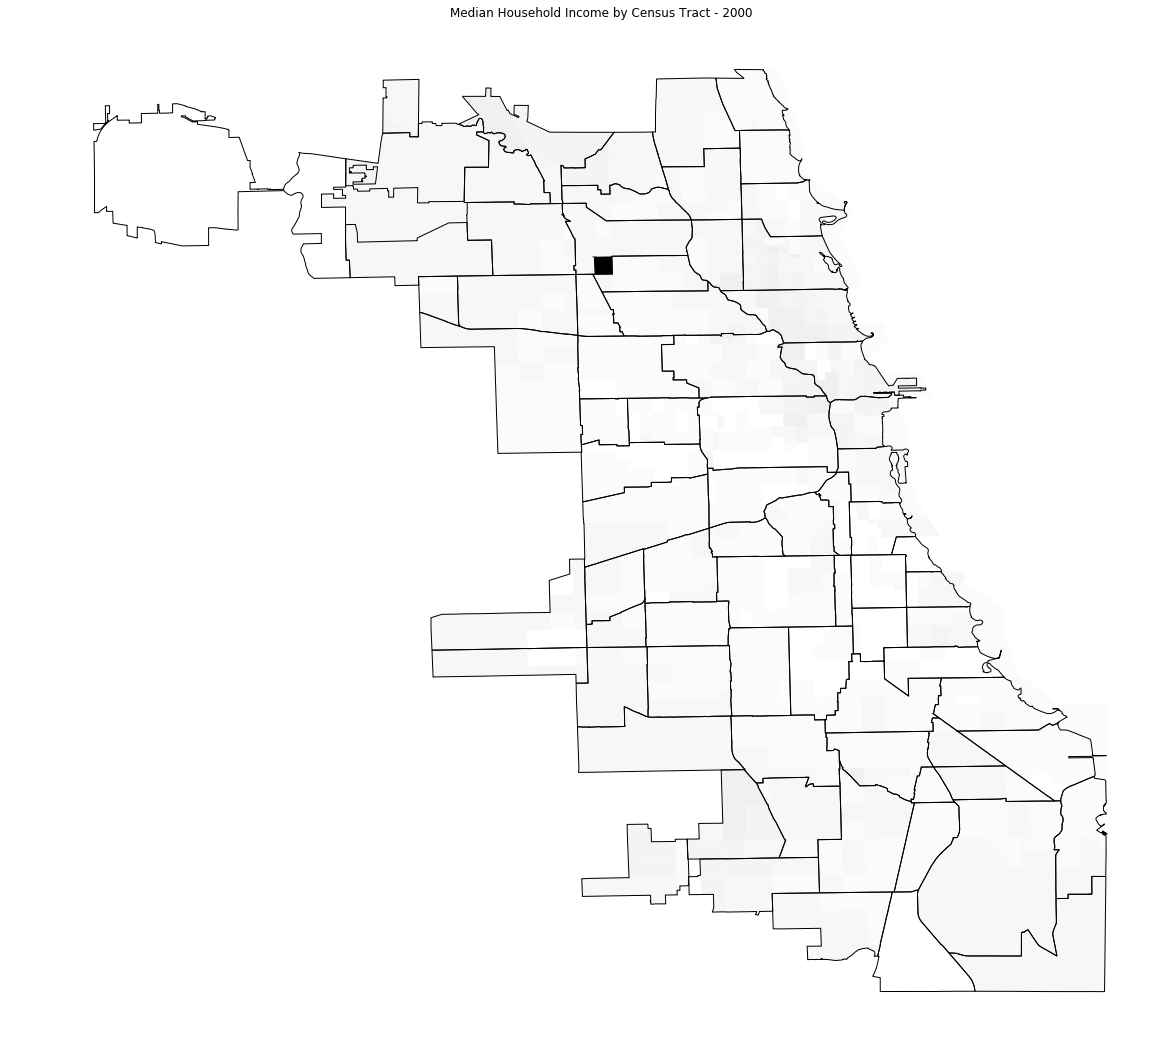

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

income_ranges = np.array(["",
                          "$0      - $20,000",
                          "$20,001 - $40,000",
                          "$40,001 - $60,000",
                          "$60,001 - $80,000",
                          "$80,001 +"
                         ])

ax.set_aspect('equal')
ax.axis('off')
    
cMap = plt.get_cmap('Greys')
levels = np.linspace(0, 5, 6, dtype=int)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cMap.N, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: income_ranges[::-1][norm(x)])

ax.set_title('Median Household Income by Census Tract - 2000')
census2k.plot(ax=ax, column="income_range",  cmap=cMap)
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('output/census-mhi.png', bbox_inches='tight')
else:
    plt.show()

KeyError: 'category'

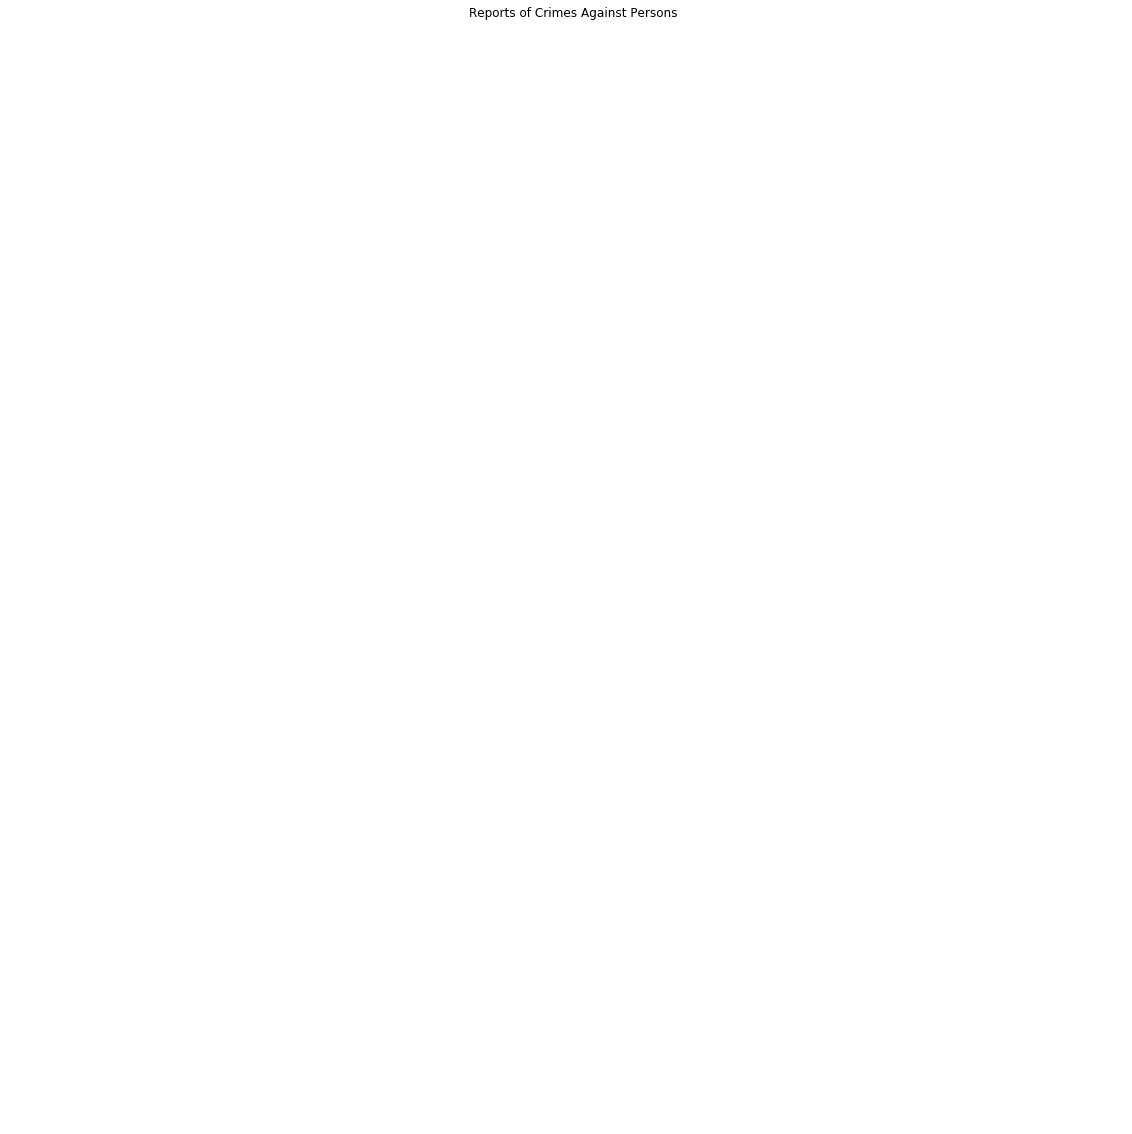

In [22]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Reports of Crimes Against Persons')
ax.set_aspect('equal')
ax.axis('off')
my_heatmap, extent = heatmap(crimes.loc[lambda crimes: crimes['category'] == 'person', :],
                             bins=(100, 100), smoothing=1.3, cmap=cMap)
plt.imshow(my_heatmap, extent=extent, cmap=cMap)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('police-reports-person.png', bbox_inches='tight')
else:
    plt.show()